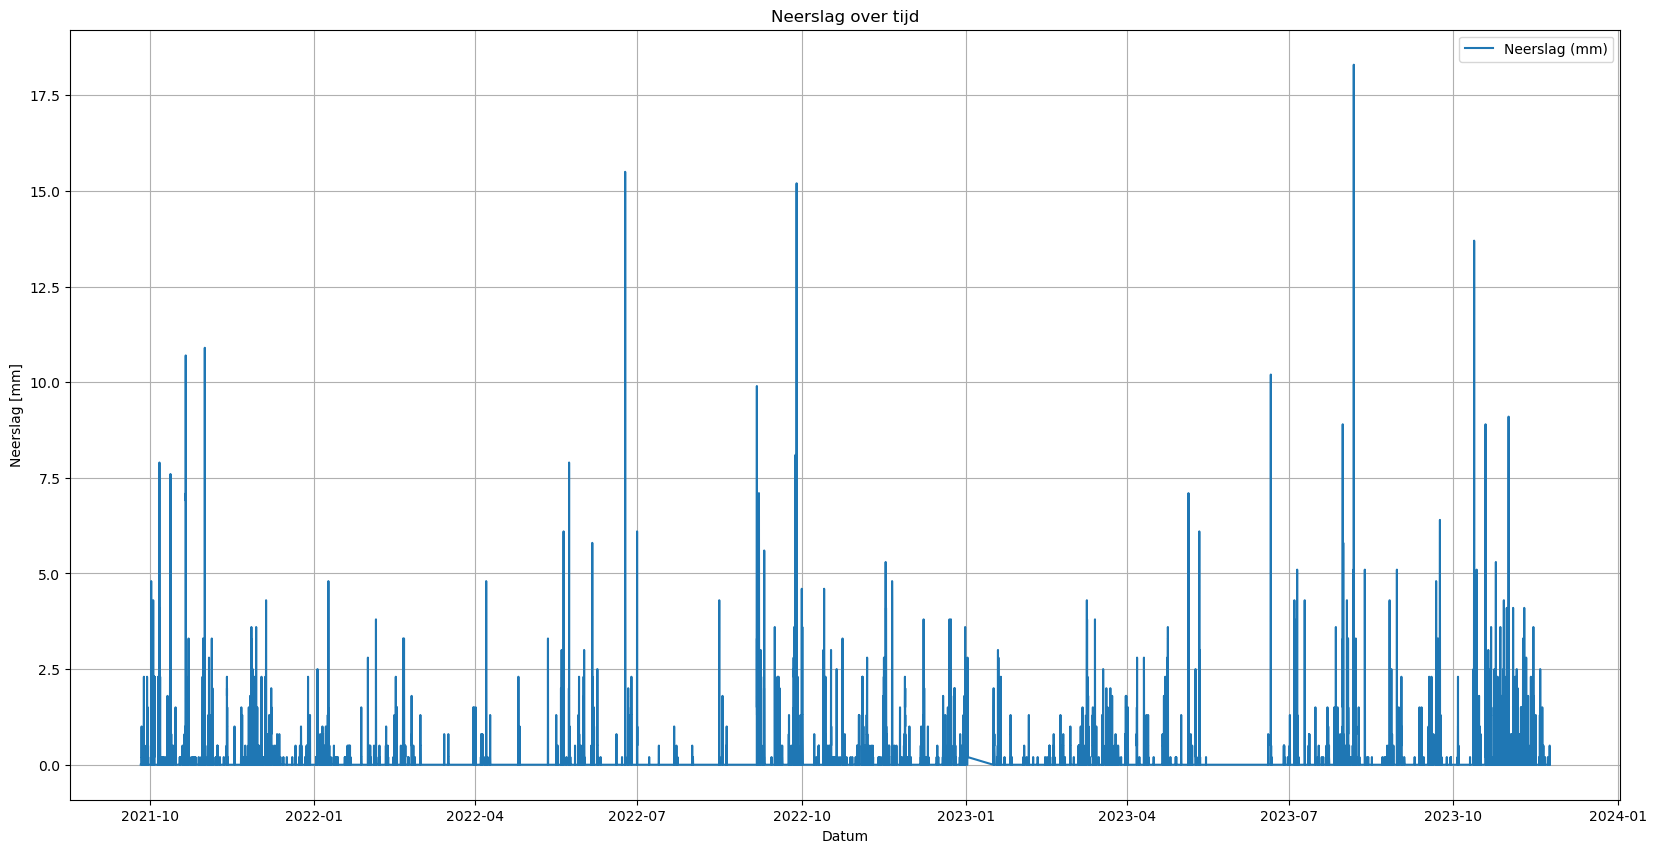

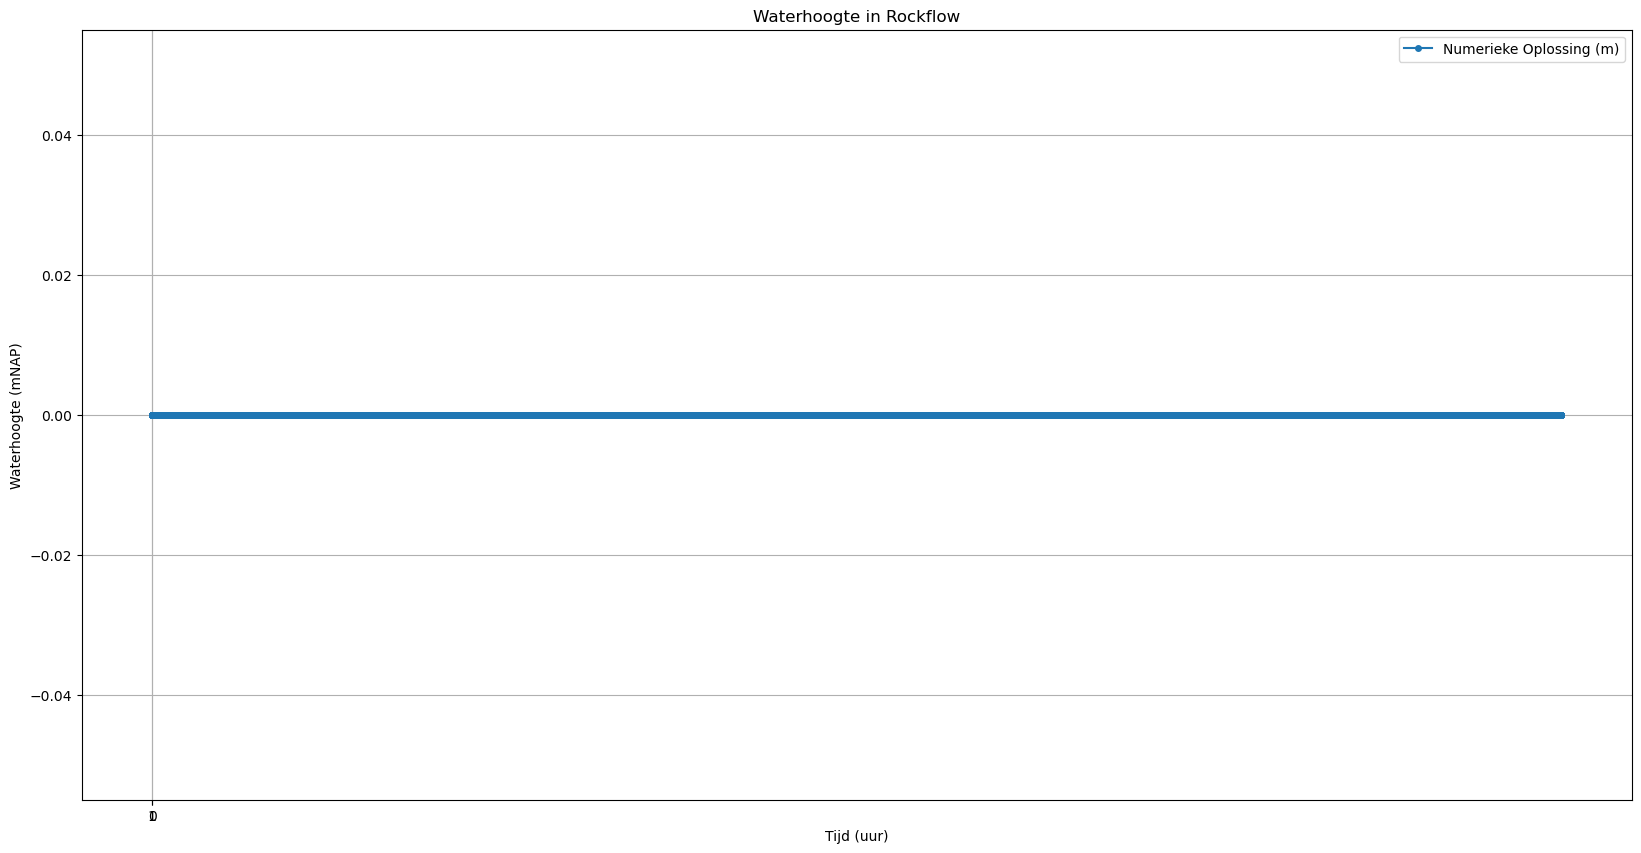

In [33]:
#Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Plot de DateTime tegenover de RH
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], df_neerslag["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd")
plt.xlabel("Datum")
plt.ylabel("Neerslag [mm]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_neerslag['neerslagintensiteit (mm/uur)'].tolist()

# Toon de lijst van alle waarden van 'neerslagintensiteit (mm/uur)'
#print("Lijst van alle waarden van 'neerslagintensiteit (mm/uur)':")
#print(neerslag_lijst)


#Invoer van KNMI dataset in het model van de waterbergende weg

# Parameters
A_hellend_dak = 660.88
A_vlak_dak = 56.12
A_rijweg_goot = 836.99
A_trottoir_goot = 532.36
A_parkeerplaatsen = 570.08

A_afstromend = A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_parkeerplaatsen
A_inf_pakket = 1337.53   #Oppervlak van het bergend pakket (m^2)
A_zandpakket = 0.70*180
k_bodem = 0.05/24/12   #Doorlatendheidscoëfficiënt van de bodem (m/5min)
k_rockflow = 200/24/12 #Doorlatendheidscoëfficiënt van de rockflow (m/5min)
k_zand = 10/24/12
por_bodem = 0.4
por_rockflow = 0.95
por_zand = 0.25
t0 = 0
Onderkant_wegcunet = -1.08  #In mNAP

tijdstappen = len(neerslag_lijst)

# Tijdstappen en initiële conditie
dt = 1  # Tijdstap (5 minuten)
t = np.arange(0, tijdstappen, dt)  # Tijdstappen
V = np.zeros(len(t))  # Array voor de bergingscapaciteit
h = np.zeros(len(t))  # Array voor de waterhoogte in het infiltratiepakket

# Initiële conditie
V[0] = 0.0  # Initiële bergingscapaciteit (m^3)

# Numerieke oplossing met behulp van de methode van Euler
for i in range(1, len(t)):
    dVdt = (neerslag_lijst[i] * A_afstromend - k_zand * A_zandpakket)
    V[i] = max(0, V[i - 1] + dVdt * dt)
    h[i] = max(0, V[i] / por_rockflow / A_inf_pakket + Onderkant_wegcunet)

# Plot de numerieke oplossing voor het volume (verbeterde x-as)
#plt.figure(figsize=(20, 10))
#plt.plot(df_neerslag["DateTime"], V, label='Numerieke Oplossing (m^3)', marker='o', markersize=4, linestyle='-')
#plt.xlabel('Tijd (jaren)')  # Verander x-as label naar 'Tijd (jaren)'
#plt.ylabel('Bergingscapaciteit (m^3)')
#plt.title('Numerieke Oplossingen van de Bergingscapaciteit met Dagelijkse Neerslagsom')
#plt.legend()
#plt.grid(True)
#plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Alleen de jaren laten zien
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.xticks(rotation=45)  # Roteren van de waardes op de x-as
#plt.show()

# Plot de numerieke oplossing voor waterhoogte
plt.figure(figsize=(20, 10))
plt.plot(t, h, label='Numerieke Oplossing (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Tijd (uur)')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Waterhoogte in Rockflow')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 2, 1))  # Tijdstapmarkeringen om de 1 dag
plt.show()


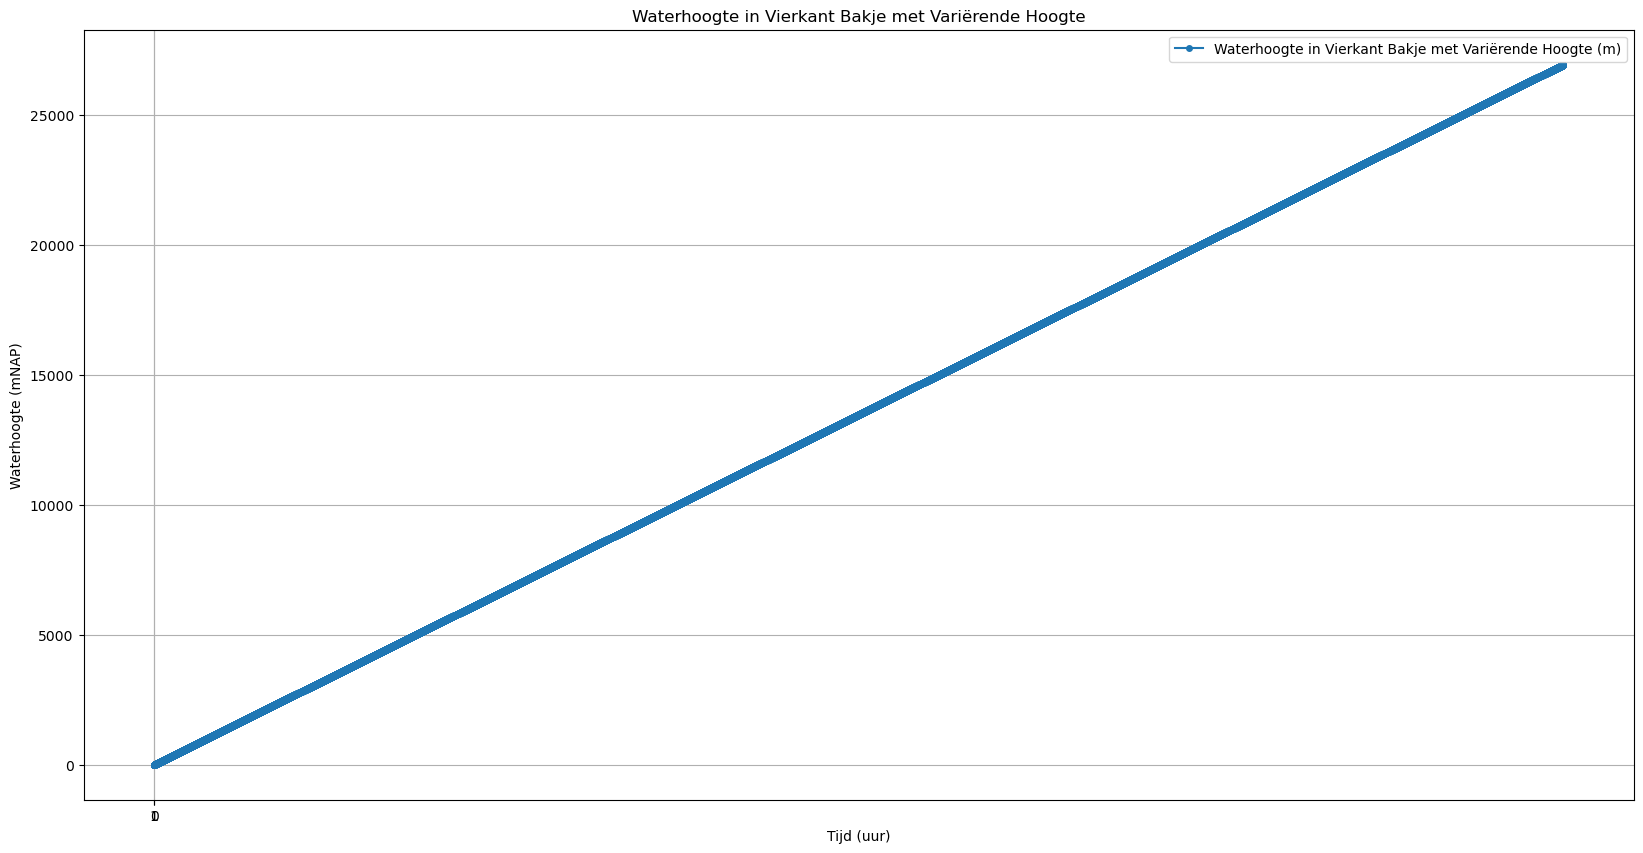

In [31]:
# Initiële conditie voor het drainzandpakket met variërende hoogte
V_drainzand_variabel = np.zeros(len(t))  # Array voor de bergingscapaciteit van het vierkante bakje
h_water_in_drainzand = np.zeros(len(t))  # Array voor de waterhoogte in het vierkante bakje
V_drainzand_variabel[0] = 0.0  # Initiële bergingscapaciteit van het vierkante bakje (m^3)

# Numerieke oplossing voor het vierkante bakje met variërende hoogte
for i in range(1, len(t)):
    dVdt_drainzand = (k_zand * A_zandpakket)
    V_drainzand_variabel[i] = max(0, V_drainzand_variabel[i - 1] + dVdt_drainzand * dt)
    h_water_in_drainzand[i] = max(0, V_drainzand_variabel[i] / por_zand / A_zandpakket)

# Plot de numerieke oplossing voor waterhoogte in het vierkante bakje met variërende hoogte
plt.figure(figsize=(20, 10))
plt.plot(t, h_water_in_drainzand, label='Waterhoogte in Vierkant Bakje met Variërende Hoogte (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Tijd (uur)')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Waterhoogte in Vierkant Bakje met Variërende Hoogte')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 2, 1))  # Tijdstapmarkeringen om de 1 dag
plt.show()

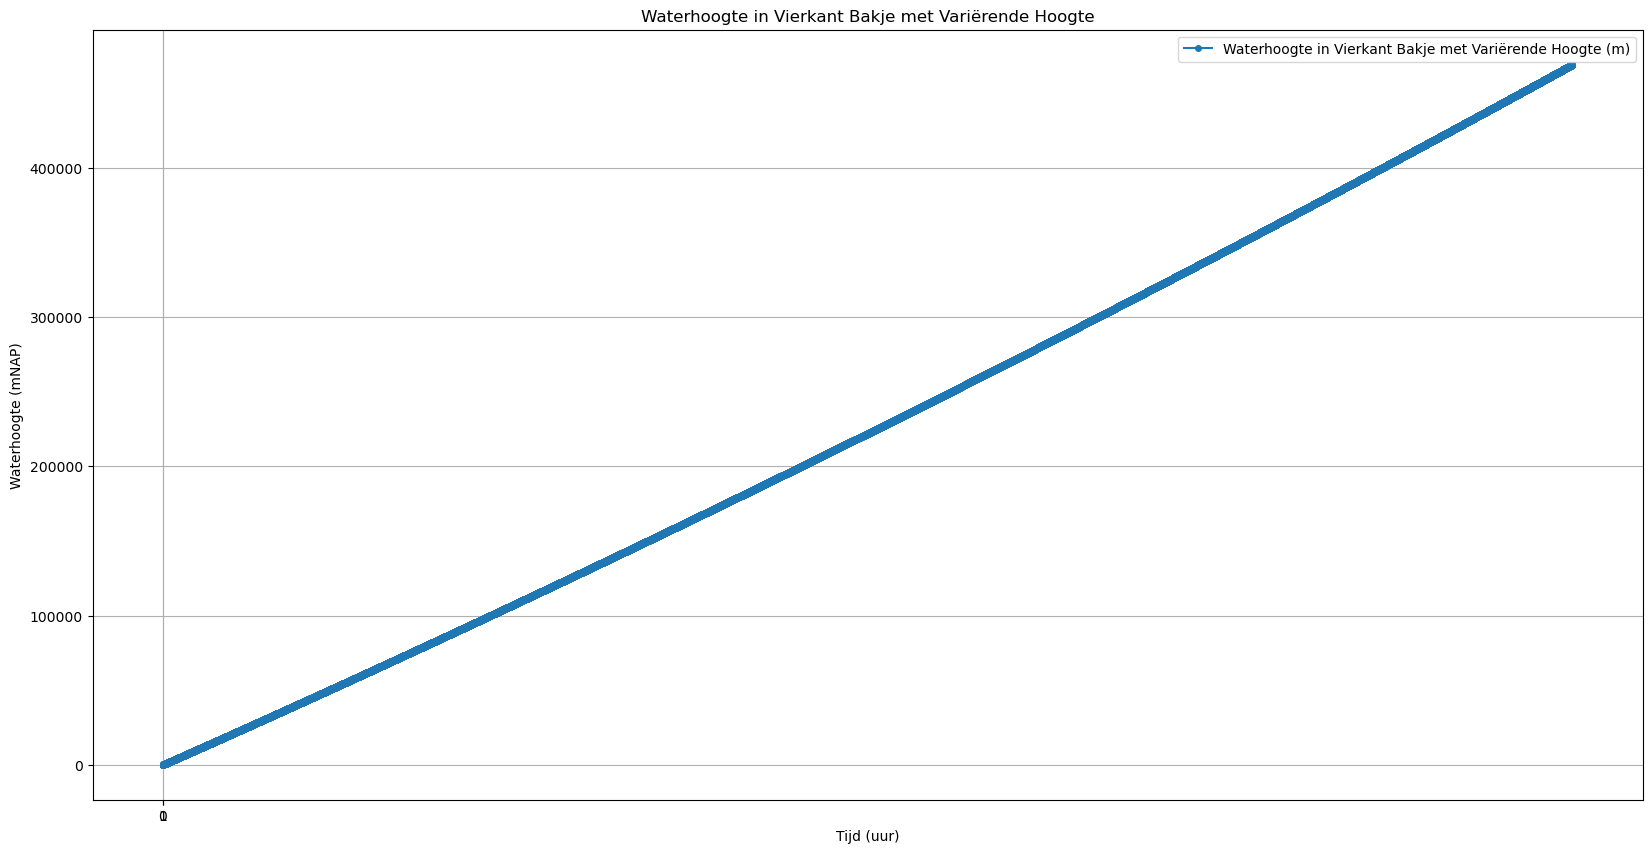

In [25]:
# Parameters voor het vierkante bakje met variërende hoogte
A_vierkant = 100.0  # oppervlakte van het vierkante bakje (m^2)
k_vierkant = 0 #8.0/24/12  # doorlatendheidscoëfficiënt van het vierkante bakje (m/5min)
por_vierkant = 0.25  # porositeit van het vierkante bakje

# Hoogteprofiel over de lengte van de weg (bijvoorbeeld lineair stijgend)
hoogteprofiel = np.linspace(0.54, 0.67, len(t))  # pas dit aan op basis van je gewenste profiel

# Initiële conditie voor het vierkante bakje met variërende hoogte
V_vierkant_variabel = np.zeros(len(t))  # Array voor de bergingscapaciteit van het vierkante bakje
h_water_vierkant_variabel = np.zeros(len(t))  # Array voor de waterhoogte in het vierkante bakje
V_vierkant_variabel[0] = 0.0  # Initiële bergingscapaciteit van het vierkante bakje (m^3)

# Numerieke oplossing voor het vierkante bakje met variërende hoogte
for i in range(1, len(t)):
    dVdt_vierkant_variabel = (hoogteprofiel[i] * A_vierkant - k_vierkant * A_vierkant)
    V_vierkant_variabel[i] = max(0, V_vierkant_variabel[i - 1] + dVdt_vierkant_variabel * dt)
    h_water_vierkant_variabel[i] = max(0, V_vierkant_variabel[i] / por_vierkant / A_vierkant)

# Plot de numerieke oplossing voor waterhoogte in het vierkante bakje met variërende hoogte
plt.figure(figsize=(20, 10))
plt.plot(t, h_water_vierkant_variabel, label='Waterhoogte in Vierkant Bakje met Variërende Hoogte (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Tijd (uur)')
plt.ylabel('Waterhoogte (mNAP)')
plt.title('Waterhoogte in Vierkant Bakje met Variërende Hoogte')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 2, 1))  # Tijdstapmarkeringen om de 1 dag
plt.show()


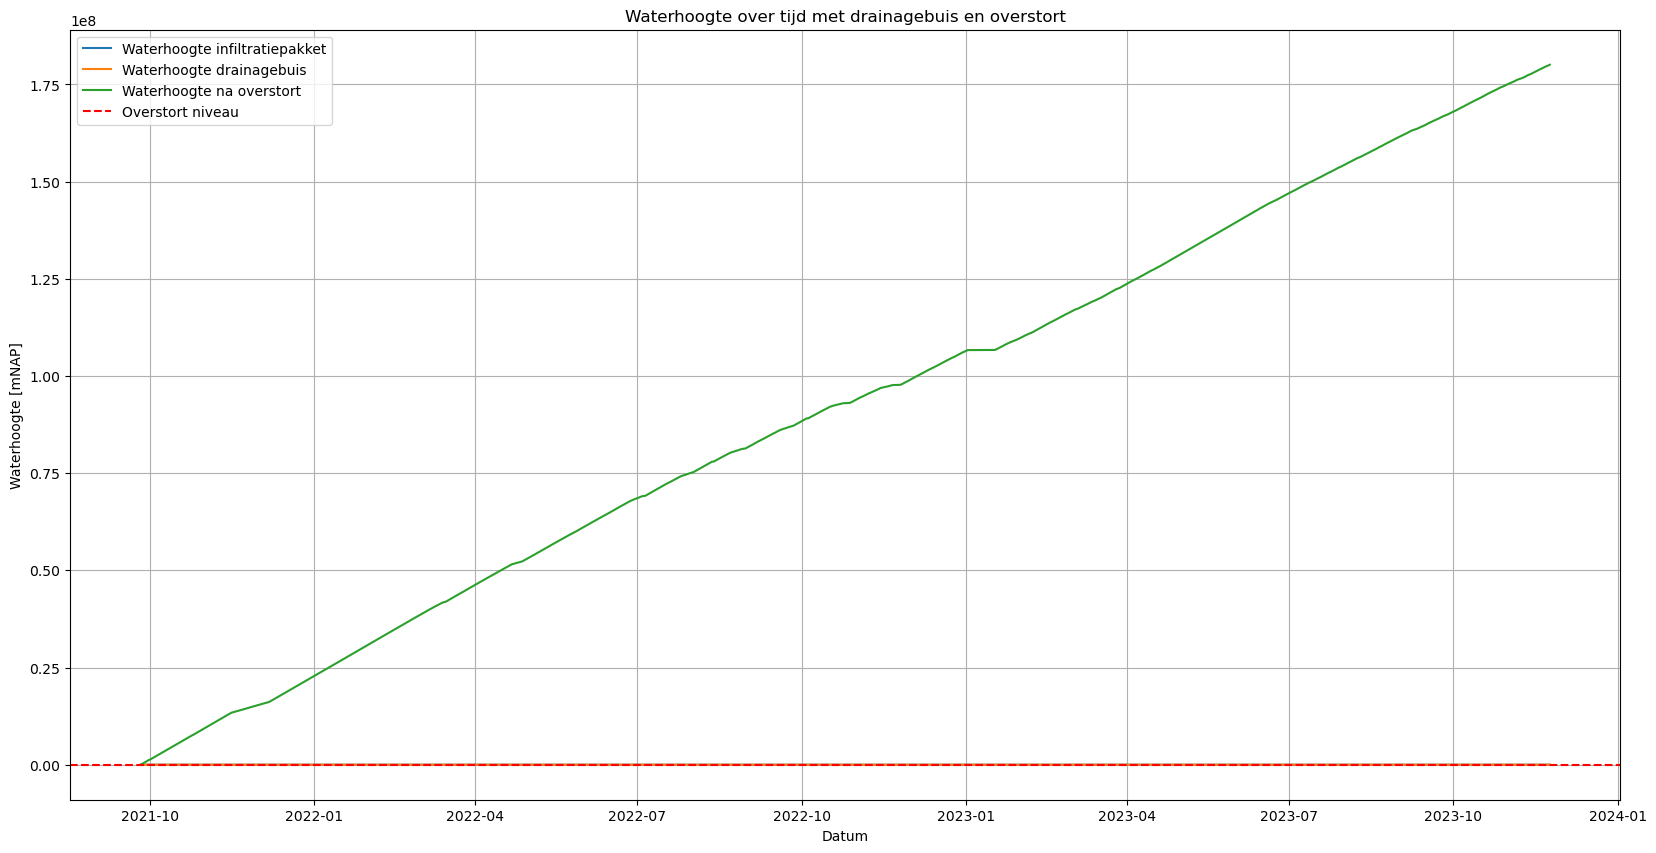

In [26]:
# Aanpassingen voor drainagebuis met overstort
diameter_drainagebuis = 0.2  # Diameter van de drainagebuis (m)
hoogte_overstort = -1.0  # Hoogte van de overstort (mNAP)

# Arrays voor de waterhoogte in de drainagebuis en de waterhoogte na overstort
h_drainagebuis = np.zeros(len(t))
h_overstort = np.zeros(len(t))

# Initiële condities voor drainagebuis en overstort
h_drainagebuis[0] = 0.0
h_overstort[0] = 0.0

# Toevoegen van drainagebuis en overstort aan de numerieke oplossing
for i in range(1, len(t)):
    dVdt = (neerslag_lijst[i] * A_afstromend - k_bodem * A_inf_pakket)
    V[i] = max(0, V[i - 1] + dVdt * dt)
    
    # Waterhoogte in het infiltratiepakket
    h[i] = max(0, V[i] / por_rockflow / A_inf_pakket + Onderkant_wegcunet)
    
    # Waterhoogte in de drainagebuis
    dV_drainagebuis_dt = k_bodem * A_inf_pakket - k_rockflow * A_inf_pakket
    h_drainagebuis[i] = max(0, h_drainagebuis[i - 1] + dV_drainagebuis_dt * dt)
    
    # Waterhoogte na overstort
    if h_drainagebuis[i] > hoogte_overstort:
        dV_overstort_dt = k_rockflow * A_inf_pakket
        h_overstort[i] = max(0, h_overstort[i - 1] + dV_overstort_dt * dt)
    else:
        h_overstort[i] = 0.0

# Plot resultaten
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], h, label="Waterhoogte infiltratiepakket")
plt.plot(df_neerslag["DateTime"], h_drainagebuis, label="Waterhoogte drainagebuis")
plt.plot(df_neerslag["DateTime"], h_overstort, label="Waterhoogte na overstort")
plt.axhline(y=hoogte_overstort, color='r', linestyle='--', label="Overstort niveau")
plt.title("Waterhoogte over tijd met drainagebuis en overstort")
plt.xlabel("Datum")
plt.ylabel("Waterhoogte [mNAP]")
plt.grid(True)
plt.legend()
plt.show()


,object_id,description,well_covering_project_code,result_timestamp,water_level,water_level_unit,DateTime
0,5361029,PB1.03 (Rockflow),215231,26-6-2021 15:59,-1.102,m (NAP),2021-06-26 15:59:00
1,5361029,PB1.03 (Rockflow),215231,26-6-2021 16:59,-1.069,m (NAP),2021-06-26 16:59:00
2,5361029,PB1.03 (Rockflow),215231,26-6-2021 17:59,-1.056,m (NAP),2021-06-26 17:59:00
3,5361029,PB1.03 (Rockflow),215231,26-6-2021 18:59,-1.056,m (NAP),2021-06-26 18:59:00
4,5361029,PB1.03 (Rockflow),215231,26-6-2021 19:59,-1.051,m (NAP),2021-06-26 19:59:00
...,...,...,...,...,...,...,...
6427,5361029,PB1.03 (Rockflow),215231,22-11-2023 05:00,-1.068,m (NAP),2023-11-22 05:00:00
6428,5361029,PB1.03 (Rockflow),215231,22-11-2023 06:00,-1.076,m (NAP),2023-11-22 06:00:00
6429,5361029,PB1.03 (Rockflow),215231,22-11-2023 07:00,-1.073,m (NAP),2023-11-22 07:00:00
6430,5361029,PB1.03 (Rockflow),215231,22-11-2023 08:00,-1.072,m (NAP),2023-11-22 08:00:00


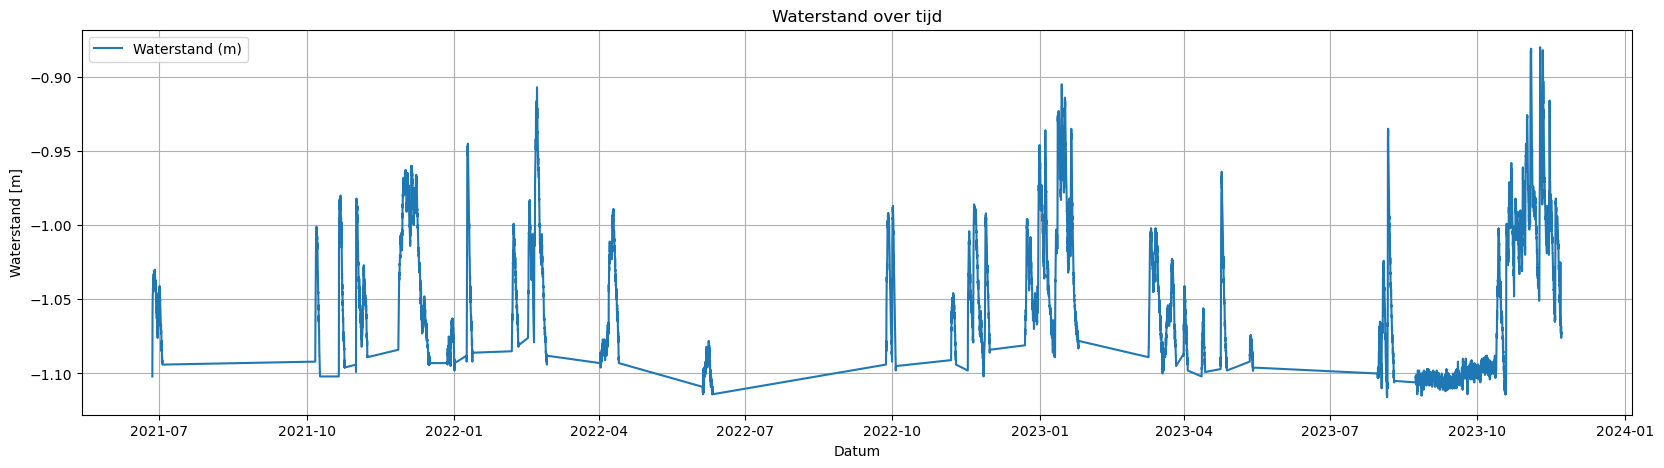

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')
# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Toon de kolomnamen
#print(df_PB03.columns)
display(df_PB03)
#df_PB03.head(20)

#plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_PB03["DateTime"], df_PB03["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

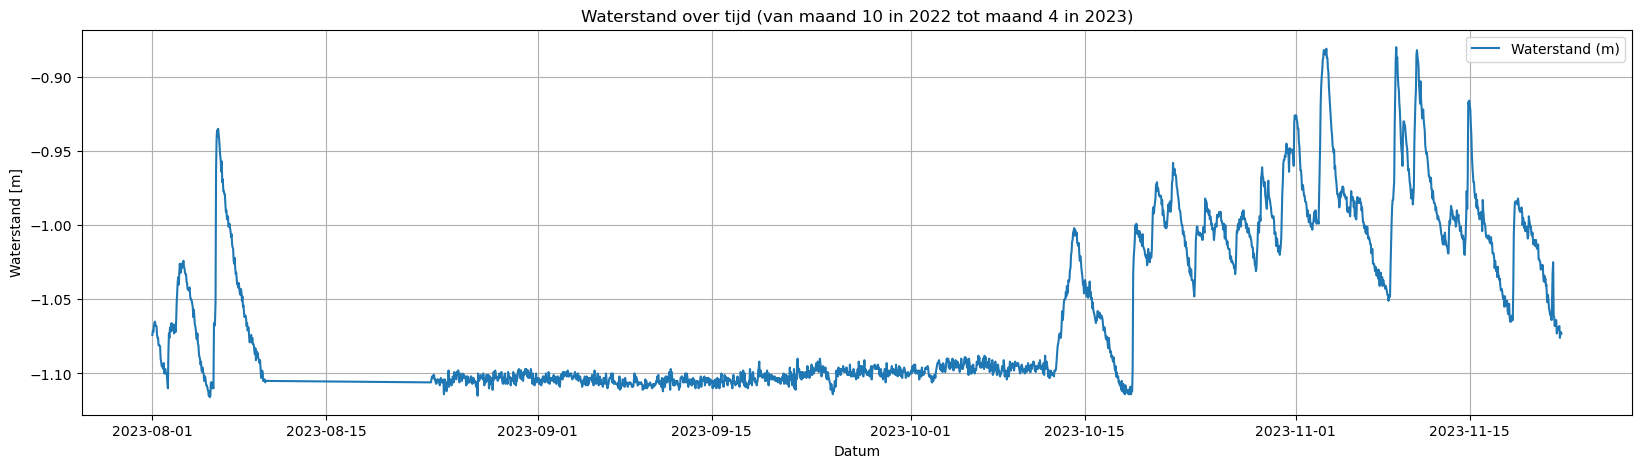

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Filter het DataFrame op het gewenste tijdsinterval (van maand 10 in 2022 tot maand 4 in 2023)
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-11-30')
df_filtered = df_PB03[(df_PB03['DateTime'] >= start_date) & (df_PB03['DateTime'] <= end_date)]

# Plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_filtered["DateTime"], df_filtered["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd (van maand 10 in 2022 tot maand 4 in 2023)")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

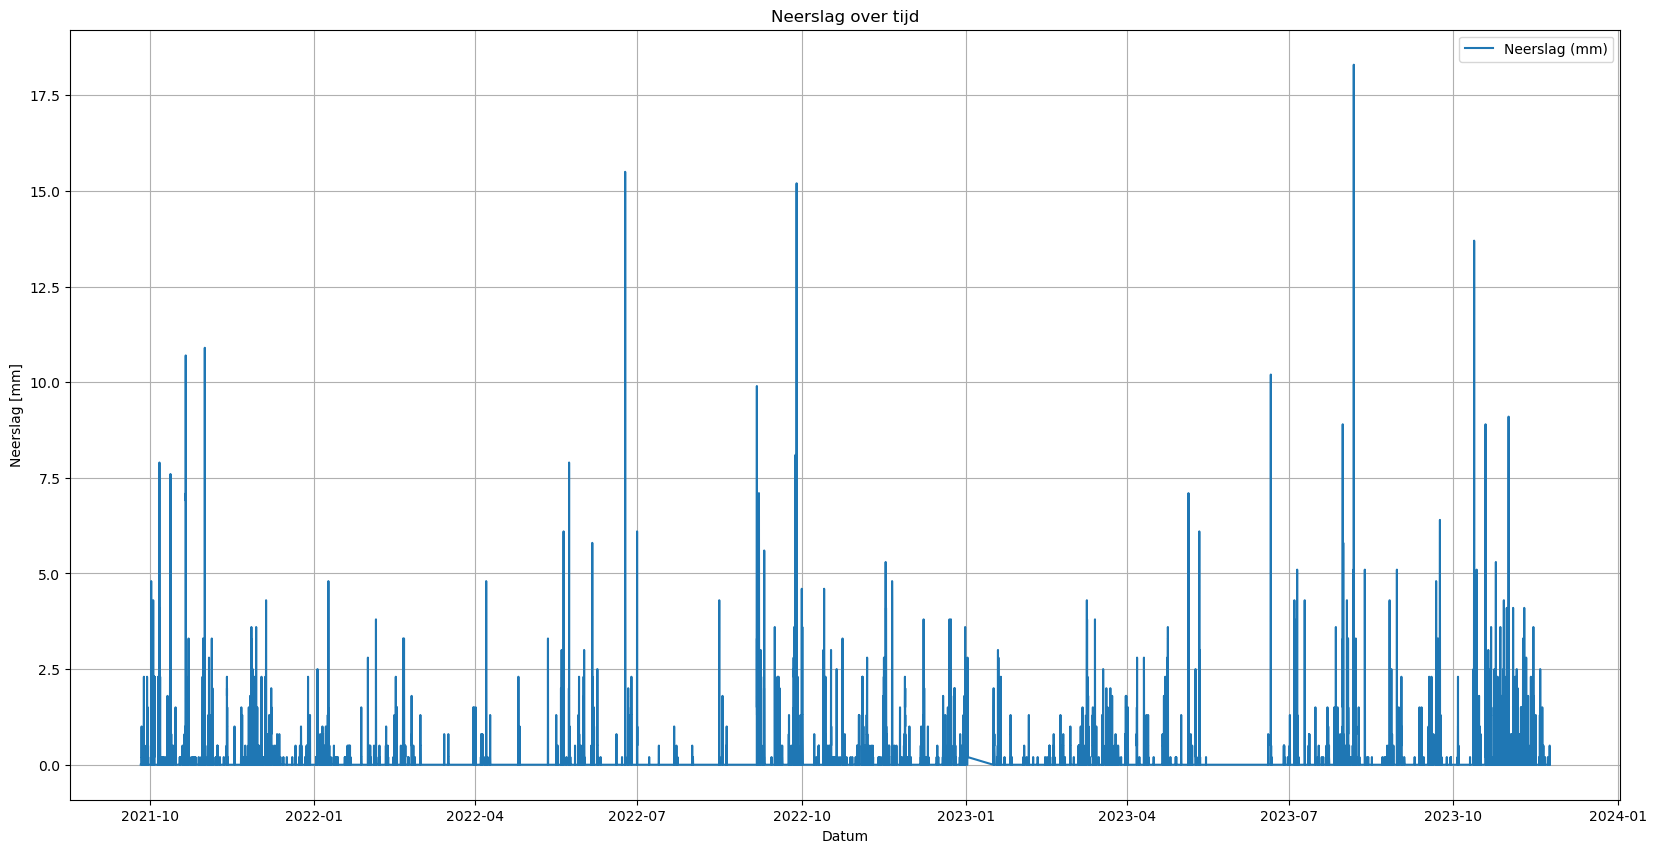

In [29]:
# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Plot de DateTime tegenover de RH
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], df_neerslag["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd")
plt.xlabel("Datum")
plt.ylabel("Neerslag [mm]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_neerslag['neerslagintensiteit (mm/uur)'].tolist()

# Toon de lijst van alle waarden van 'neerslagintensiteit (mm/uur)'
#print("Lijst van alle waarden van 'neerslagintensiteit (mm/uur)':")
#print(neerslag_lijst)
